---
# Modelling hippocampal neurons of animals navigating in VR with recurrent neural networks
### Marco P. Abrate, Daniel Liu
---

##### Outline
Rat simulation:
- Motion model (RatInABox)
- Environment design (Blender)
- Simulated rat vision (ratvision)

Vision autoencoder

Hippocampus model (RNN):
- RNN definition
- Data loading
- Training

Hidden state representations analysis:
- Rate maps
- Polar maps
- Quantitive metrics
- Comparison with real data

---
## **Part 2: Training a Vision Autoencoder**

In this notebook, we will write code to train an **Autoencoder**. An autoencoder is a pair of artificial neural networks that compresses information into a low-dimensional embedding through the first module (aka encoder) and reconstructs it to its original form through the second module (aka decoder).

Neuroscientists use vision autoencoders to model how neurons might represent visual stimuli in the brain. The visual cortex receives complex images and it is able to extract key features - such as edges, motions and shapes - into more compact forms (low-dimensional embedding). This non-linear dimensionality reduction process, along with the reconstruction of the original image, can be compared to an autoencoder.

We will use the **PyTorch** package for this tutorial.

Before starting this notebook, make sure you have:
- video recordings from part 1.

### **0. Install and import dependencies**

In [1]:
!pip install torch torchvision torchaudio
!pip install scikit-learn
!pip install matplotlib

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import itertools
from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
    
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

### **1. Visualize example frame**

In [3]:
d = '../data/visual_ae_data'

trial_paths = [p for p in Path(d).iterdir() if 'exp' in p.name]

trial_paths

[PosixPath('../data/visual_ae_data/exp_dim0.635_fps10_s720_seed09'),
 PosixPath('../data/visual_ae_data/exp_dim0.635_fps10_s720_seed19'),
 PosixPath('../data/visual_ae_data/exp_dim0.635_fps10_s720_seed24'),
 PosixPath('../data/visual_ae_data/exp_dim0.635_fps10_s720_seed12'),
 PosixPath('../data/visual_ae_data/exp_dim0.635_fps10_s720_seed14'),
 PosixPath('../data/visual_ae_data/exp_dim0.635_fps10_s720_seed13'),
 PosixPath('../data/visual_ae_data/exp_dim0.635_fps10_s720_seed25'),
 PosixPath('../data/visual_ae_data/exp_dim0.635_fps10_s720_seed04'),
 PosixPath('../data/visual_ae_data/exp_dim0.635_fps10_s720_seed21'),
 PosixPath('../data/visual_ae_data/exp_dim0.635_fps10_s720_seed07'),
 PosixPath('../data/visual_ae_data/exp_dim0.635_fps10_s720_seed22'),
 PosixPath('../data/visual_ae_data/exp_dim0.635_fps10_s720_seed17'),
 PosixPath('../data/visual_ae_data/exp_dim0.635_fps10_s720_seed03'),
 PosixPath('../data/visual_ae_data/exp_dim0.635_fps10_s720_seed16'),
 PosixPath('../data/visual_ae_data

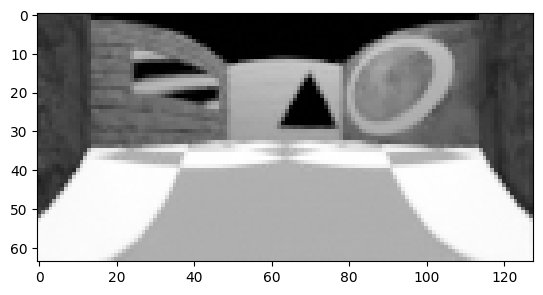

In [4]:
frame_example = trial_paths[0] / 'box_messy' / 'frame0001.png'
plt.imshow(np.array(Image.open(frame_example)), cmap='gray')
plt.show()

In [5]:
IMG_DIM = (64, 128) # (height, width) of the input images
GS = True # whether to use grayscale images

### **2. Load frames**

The ```preprocess_frame``` accepts the path of a frame, then converts it to RGB values and normalise it 1 so that we have a ```(channels, height, width)``` array of numbers between 0 and 1.

Optionally, the frame can be converted to grayscale, so that the channel dimension is 1.

In [6]:
def preprocess_frame(frame, grayscale):
    img = Image.open(frame)
    if grayscale: 
        img = img.convert('L')
    img = np.array(img, dtype=np.float32)

    # normalise RGB to (0, 1) scale
    img = img / 255.
    
    if grayscale:
        img = img[None, ...] # (1, h, w) if grayscale
    else:
        img = np.moveaxis(img, -1, 0) # reshape to (3, h, w) if RGB

    return img

def preprocess_frame_batch(all_frames, batch_indices, grayscale):
    # preprocess a batch of frames
    imgs = np.array([
        preprocess_frame(all_frames[idx], grayscale)
        for idx in batch_indices
    ])
    return imgs

In [7]:
globs = [(tp/'box_messy').glob('*.png') for tp in trial_paths]
all_frames = [f for g in globs for f in g]

In [8]:
# Split dataset into train and test sets
BATCH_SIZE = 32
TEST_SET_PROP = 0.1 # 10%

train_indices, test_indices = train_test_split(
    np.arange(len(all_frames)), test_size=TEST_SET_PROP, shuffle=True, random_state=SEED
)

In [9]:
train_imgs = preprocess_frame_batch(
    all_frames, train_indices, grayscale=GS
)
test_imgs = preprocess_frame_batch(
    all_frames, test_indices, grayscale=GS
)

print(f"Train set shape: {train_imgs.shape}")
print(f"Test set shape: {test_imgs.shape}")

Train set shape: (168480, 1, 64, 128)
Test set shape: (18720, 1, 64, 128)


In [10]:
from autoencoder.datasets import UnlabeledDataset

dataloader_train = torch.utils.data.DataLoader(
    UnlabeledDataset(torch.from_numpy(train_imgs)),
    batch_size=BATCH_SIZE, shuffle=True
)
dataloader_test = torch.utils.data.DataLoader(
    UnlabeledDataset(torch.from_numpy(test_imgs)),
    batch_size=BATCH_SIZE, shuffle=True
)

### **3. Vision autoencoder definition**

As we mentioned before, an autoencoder is a type of neural network that learns to compress data into a smaller representation (encoding) and then reconstruct it back (decoding).

There is no restriction on the structure of the encoder and the decoder, and they need not be symmetric. 

However, since we are processing image frames, **convolutional layers** will be helpful becuase they can:
- capture spatial features like edges, textures, shapes, etc.
- preserve local patterns and share weights across image
- detect features efficiently regardless of position

In [11]:
from autoencoder.vision_ae import VisualEncoder, VisualDecoder

KERNEL_SIZES = [(3,3), (4,4), (4,4), (3,3)] # kernel sizes for the convolutional layers
KERNEL_STRIDES = [1, 2, 2, 1] # strides
CHANNELS = [8, 8, 16, 16] # number of channels

EMB_DIM = 100 # the number of neurons in the latent space (or number of latent features)

img_dim_out = IMG_DIM

print('Need to make sure all numbers are INTEGERS!\n')
print(f'Input dimension:\t\t{1 if GS else 3}x {IMG_DIM}')
for i in range(len(KERNEL_SIZES)):
    ksize = KERNEL_SIZES[i]
    stride = KERNEL_STRIDES[i]

    img_dim_out = [
        (img_dim_out[i] - ksize[i])/stride + 1
        for i in range(len(IMG_DIM))
    ]
    
    print(f'Intermediate dimension {i+1}:\t{CHANNELS[i]}x {img_dim_out}')

print(f'Flattens to:\t\t\t{np.prod(img_dim_out)*CHANNELS[-1]}\n')


Need to make sure all numbers are INTEGERS!

Input dimension:		1x (64, 128)
Intermediate dimension 1:	8x [62.0, 126.0]
Intermediate dimension 2:	8x [30.0, 62.0]
Intermediate dimension 3:	16x [14.0, 30.0]
Intermediate dimension 4:	16x [12.0, 28.0]
Flattens to:			5376.0



In [12]:
encoder = VisualEncoder(
    visual_embedding_dim = EMB_DIM,
    img_dim = IMG_DIM,
    grayscale = GS,
    kernel_sizes = KERNEL_SIZES,
    kernel_strides = KERNEL_STRIDES,
    channels = CHANNELS
).to(DEVICE)

decoder = VisualDecoder(
    visual_embedding_dim = EMB_DIM,
    img_dim_out = encoder.img_dim_out,
    grayscale = GS,
    kernel_sizes = KERNEL_SIZES,
    kernel_strides = KERNEL_STRIDES,
    channels = CHANNELS
).to(DEVICE)

Encoder convolution layer: Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (2): ReLU()
  (3): Conv2d(8, 8, kernel_size=(4, 4), stride=(2, 2))
  (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (5): ReLU()
  (6): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2))
  (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (8): ReLU()
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (11): ReLU()
)
Final convolution size: 16x[12, 28]
Flattens to 5376

Encoder linear layer: Sequential(
  (0): Linear(in_features=5376, out_features=100, bias=True)
  (1): Sigmoid()
)

Decoder linear layer: Linear(in_features=100, out_features=5376, bias=True)

Decoder convolution layer: Sequential(
  (0): ConvTranspose2d(16, 16, kernel_size=

Now that we have defined our encoder and decoder, let's see an example of the reconstruction.

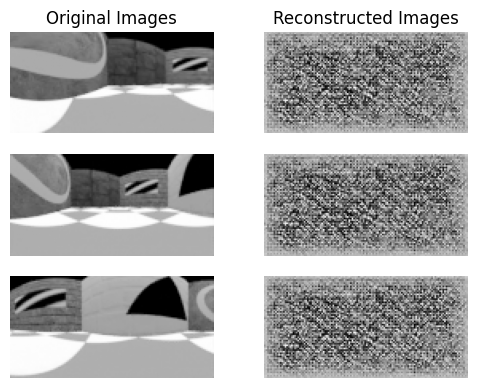

In [13]:
# visualise examples
with torch.no_grad():
    for example_batch in dataloader_test:
        example_batch = example_batch[np.random.choice(len(example_batch), size=3, replace=False)]
        example_batch = example_batch.to(DEVICE)
        example_batch_recon = decoder(encoder(example_batch))

        fig, axs = plt.subplots(len(example_batch), 2, figsize=(6, 1.5*len(example_batch)))
        axs.flat[0].set_title('Original Images')
        axs.flat[1].set_title('Reconstructed Images')
        for i, (frame_example_img, frame_example_recon) in enumerate(zip(example_batch, example_batch_recon)):
            axs[i, 0].imshow(frame_example_img.cpu().numpy().squeeze(), cmap='gray')
            axs[i, 1].imshow(frame_example_recon.cpu().numpy().squeeze(), cmap='gray')
            axs[i, 0].axis('off')
            axs[i, 1].axis('off')
        plt.show()

        break

This looks like just noise. This is because the autoencoder is untrained. But the good news is: at least we got the dimensions correct!

Now, let's train the pair of networks.

### **4. Autoencoder training**

* **Train the model**. This includes a forward pass, computing loss, backpropagation and update weights

* If needed, **validate** on the validation set to tune hyperparameters.

* **Test** the trained model on unseen data to evaluate performance.

* Once the model has reached satisfactory performance, it is ready for **deployment**.

In [ ]:
# Define the train and test functions

def train_epoch(
    enc, dec,
    dataloader_train,
    loss_fn, optimizer
):
    enc.train()
    dec.train()
    epoch_loss = 0
    
    for batch in dataloader_train:
        optimizer.zero_grad()

        batch = batch.to(DEVICE)
        
        # YOUR CODE HERE: forward pass
        batch_recon = dec(enc(batch))
        loss = loss_fn(batch_recon, batch)
        
        # YOUR CODE HERE: backward pass and optimisation step
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.detach().item()
            
    return epoch_loss / len(dataloader_train)

def test_epoch(
    enc, dec,
    dataloader_test,
    loss_fn,
):
    enc.eval()
    dec.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for batch in dataloader_test:
            batch = batch.to(DEVICE)
            
            # YOUR CODE HERE: forward pass
            batch_recon = dec(enc(batch))
            loss = loss_fn(batch_recon, batch)
            
            epoch_loss += loss.detach().item()
    
    return epoch_loss / len(dataloader_test)

In [ ]:
# Putting it all together

n_epochs = 10 # 100 to perform a full training
learning_rate = 1e-4

loss_fn = torch.nn.L1Loss()

optimizer = torch.optim.RMSprop(
    itertools.chain(encoder.parameters(), decoder.parameters()),
    lr=learning_rate
)

# optional: use a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1,
    patience=20, threshold=1e-3
)

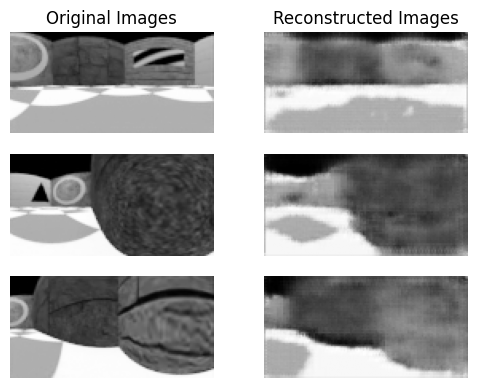

Epoch 1/10, Train Loss: 0.0684, Test Loss: 0.0520
Epoch 2/10, Train Loss: 0.0480, Test Loss: 0.0449
Epoch 3/10, Train Loss: 0.0433, Test Loss: 0.0421
Epoch 4/10, Train Loss: 0.0406, Test Loss: 0.0389
Epoch 5/10, Train Loss: 0.0387, Test Loss: 0.0377
Epoch 6/10, Train Loss: 0.0374, Test Loss: 0.0363
Epoch 7/10, Train Loss: 0.0362, Test Loss: 0.0356
Epoch 8/10, Train Loss: 0.0353, Test Loss: 0.0352
Epoch 9/10, Train Loss: 0.0346, Test Loss: 0.0341
Epoch 10/10, Train Loss: 0.0339, Test Loss: 0.0331


In [16]:
train_loss_list = []
test_loss_list = []

for epoch in range(n_epochs):
    train_loss = train_epoch(
        encoder, decoder,
        dataloader_train,
        loss_fn, optimizer
    )
    test_loss = test_epoch(
        encoder, decoder,
        dataloader_test,
        loss_fn
    )
    scheduler.step(test_loss)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    # visualize examples
    if epoch%10 == 0:
        with torch.no_grad():
            for example_batch in dataloader_test:
                example_batch = example_batch[
                    np.random.choice(len(example_batch), size=3, replace=False)
                ]
                example_batch = example_batch.to(DEVICE)
                example_batch_recon = decoder(encoder(example_batch))

                fig, axs = plt.subplots(len(example_batch), 2, figsize=(6, 1.5*len(example_batch)))
                axs.flat[0].set_title('Original Images')
                axs.flat[1].set_title('Reconstructed Images')
                for i, (frame_example, frame_recon) in enumerate(zip(example_batch, example_batch_recon)):
                    axs[i, 0].imshow(frame_example.cpu().numpy().squeeze(), cmap='gray')
                    axs[i, 1].imshow(frame_recon.cpu().numpy().squeeze(), cmap='gray')
                    axs[i, 0].axis('off')
                    axs[i, 1].axis('off')
                plt.show()
                break

    print(f'Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


### **5. Embed rat vision**

In [ ]:
encoder.load_state_dict(torch.load('encoder.pth', weights_only=True)).to(DEVICE)
encoder.eval()

VisualEncoder(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): ReLU()
    (6): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (8): ReLU()
    (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (11): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=5376, out_features=100, bias=True)
    (1): Sigmoid()
  )
)

In [15]:
d = '../data/adult'

trial_paths = [p for p in Path(d).iterdir() if 'exp' in p.name]

In [16]:
for tp in trial_paths:
    print(tp)

    frame_paths = sorted([f for f in (tp/'box_messy').glob('*.png')])

    frames = preprocess_frame_batch(
        frame_paths, np.arange(len(frame_paths)), grayscale=GS
    )
    dataloader = torch.utils.data.DataLoader(
        UnlabeledDataset(torch.from_numpy(frames)),
        batch_size=BATCH_SIZE, shuffle=False
    )
    
    batch_emb_all = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(DEVICE)
            
            batch_emb = encoder(batch)
            
            batch_emb_all.append(batch_emb.cpu().numpy())

    batch_emb_all = np.concatenate(batch_emb_all, axis=0)

    print(batch_emb_all.shape)
    np.save(tp/'vision_embeddings.npy', batch_emb_all)
    print(f'Saved embeddings to {tp/"vision_embeddings.npy"}\n')

../data/adult/exp_dim0.635_fps10_s720_seed09
(7200, 100)
Saved embeddings to ../data/adult/exp_dim0.635_fps10_s720_seed09/vision_embeddings.npy

../data/adult/exp_dim0.635_fps10_s720_seed19
(7200, 100)
Saved embeddings to ../data/adult/exp_dim0.635_fps10_s720_seed19/vision_embeddings.npy

../data/adult/exp_dim0.635_fps10_s720_seed24
(7200, 100)
Saved embeddings to ../data/adult/exp_dim0.635_fps10_s720_seed24/vision_embeddings.npy

../data/adult/exp_dim0.635_fps10_s720_seed12
(7200, 100)
Saved embeddings to ../data/adult/exp_dim0.635_fps10_s720_seed12/vision_embeddings.npy

../data/adult/exp_dim0.635_fps10_s720_seed14
(7200, 100)
Saved embeddings to ../data/adult/exp_dim0.635_fps10_s720_seed14/vision_embeddings.npy

../data/adult/exp_dim0.635_fps10_s720_seed13
(7200, 100)
Saved embeddings to ../data/adult/exp_dim0.635_fps10_s720_seed13/vision_embeddings.npy

../data/adult/exp_dim0.635_fps10_s720_seed25
(7200, 100)
Saved embeddings to ../data/adult/exp_dim0.635_fps10_s720_seed25/vision_e

### **What have we achieved in this tutorial?**

We trained a pair of autoencoders, that can compress images into a latent vector.

With a biological constraint (such as non-negative, or sigmoid), then much like the visual cortex, we can interpret the latent vector for each frame as population activity of visual neurons encoding that visual scene.

These encodings of the visual scene can now be readily fed into a **Recurrent Neural Network** to generate spatial cell tunings.